# Importer des données GPS terrain et les traduire en tableaux de vitesse et direction

Dans cette section, nouc cherchons à extraire des données GPS d'un parcours réalisé sur circuit pour le reproduire virtuellement sur Dymola. Ces informations nous permettrons d'observer le comportement latéral virtuel du véhicule en courbe, la puissance virtuelle demandée et la confronter à la réalité.

Pour cela nous devons d'abord collecter les données GPS du Goupil lors du cycle d'utilisation circuit. Pour cela, nous utilisons l'application Strava qui permet la création d'un document GPX. 

Un fichier GPX (GPS Exchange Format) contient les positions géographiques de l'objet suivi au cours du temps : sa latitude, sa longitude, son élévation (altitude) et son horodatage associé.
Exemple d'un track point GPX (point de la trace):

```xml
<trkpt lat="43.5730340" lon="1.4278220">
    <ele>146.3</ele>
    <time>2024-07-10T13:08:46Z</time>
</trkpt>
```
## Lire un document GPX :

La fonction read_gpx_file  permet de lire et de parser un fichier GPX. Elle prend en paramètre le chemin d'accès au fichier GPX (file_path) et nécessite la bibliothèque gpxpy pour analyser son contenu.

Le fichier est ouvert en mode lecture à l'aide de l'instruction with, qui garantit que le fichier sera automatiquement fermé une fois son contenu traité. Ensuite, la fonction gpxpy.parse est appelée pour transformer le fichier GPX en un objet Python structuré, appelé à propos "gpx", qui contient les données GPS du fichier. Cet objet est ensuite retourné par la fonction, permettant de manipuler et d'exploiter les informations GPS en local dans le programme, sans toucher au fichier source.


## Transformer un document GPX en tableaux temps, position :

La focntion extract_coordinates_and_times(gpx), nous permet d'extraire du .gpx, les coordonnées et les horodatages (timestamps) relevés lors du parcours en des tableaux uniques. 
Ces tableaux sont : 
- **coords** : contient les coordonnées géographiques sous la forme de tuples de latitude et de longitude.
- **times** : stocke les timestamps associés à chaque point de la trace GPS.
  
### Fonctionnement :
1. La fonction prend en entrée un fichier GPX, qui contient une ou plusieurs "track(s)" décomposée(s) en "track points". Dans notre cas il n'y a qu'une "track", qu'un seul tracé enregistré. 
2. Chaque track est composé de segments, et chaque segment contient des points GPS. PAr exemple, un nouveau segment est créé dès lors que le GPS est mis en pause. Dans notre cas, il n'y a qu'un seul segment. 
3. Pour chaque point dans un segment, la latitude, la longitude et le temps sont extraits et ajoutés aux listes `coords` et `times`.
4. Une fois toutes les données extraites, la fonction renvoie les coordonnées et les timestamps, en omettant les 62 premiers points (pour ignorer la phase d'initialisation d'attente avant le départ du véhicule).



In [1]:
def read_gpx_file(file_path):
    """Reads a GPX file and parses it."""
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    return gpx
    
def extract_coordinates_and_times(gpx):
    """Extracts latitude, longitude, and timestamp from GPX data."""
    coords = []
    times = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                coords.append((point.latitude, point.longitude))
                times.append(point.time)
    return coords[62:], times[62:]  # Skip the first 62 points




## Conversion Latitude/Longitude en Coordonnées Cartésiennes :

Les données ainsi extraites sont les latitudes et longitudes. Pour les manipuler, nous avons besoin de les transformer en coordonnées cartésiennes ayant pour origine le point de départ du tracé. 

Dans ce but, nous créons la focntion `latlon_to_cartesian` (voir ci-dessous) :

### Formule Utilisée

La fonction utilise les formules suivantes pour effectuer la conversion :

1. **Convertir les Degrés en Radians** :
   Les valeurs de latitude et de longitude sont converties de degrés en radians, en utilisant la focntion np.radian (qui fait simplement *pi/180)

2. **Calculer les Deltas** :
   On calcule les différences en radians entre les coordonnées d'un point et de l'origine.

3. **Calculer les Coordonnées Cartésiennes** :
   - La coordonnée x est calculée en tenant compte du changement de longitude et de la latitude d'origine :
   
      $
     x = R *Delta(longitude) * cos(latitude d'origine)
      $ 

   - La coordonnée y est calculée simplement à partir du changement de latitude :
   
      $
     y = R *Delta(latitude)
      $
     

  Le rayon de la Terre est approximé à `R = 6378137.0` mètres.


In [2]:
def latlon_to_cartesian(lat, lon, origin_lat, origin_lon):
    """Convertit la latitude et la longitude en coordonnées cartésiennes en mètres avec une origine donnée."""
    # Rayon de la Terre en mètres
    R = 6378137.0
    # Convertir les degrés en radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    origin_lat_rad = np.radians(origin_lat)
    origin_lon_rad = np.radians(origin_lon)
    
    # Calculer les deltas
    delta_lat = lat_rad - origin_lat_rad
    delta_lon = lon_rad - origin_lon_rad
    
    # Calculer x et y en mètres
    x = R * delta_lon * np.cos(origin_lat_rad)
    y = R * delta_lat
    
    return x, y

## Calcul de la distance parcourue entre deux points successifs :

Pour calculer la disctance parcourue entre deux points successifs, une première approche constiterait à calculer la distance entre deux points (x1,y1) et (x2,y2) successifs. Etant donné que les coordonnées sont obtenus par projection, le rayon de courbure de la terre n'est pas négligé  (bien que négligeable), l'élévation l'est en revanche. Cela n'est pas un problème étant donné que le parcours est plat. 

Calculer la distance entre deux points (x1,y1) et (x2,y2) par la formule $ d_1=\sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$ en projeté cartésien, revient, en calcul longitudinal à utiliser la formule de Haversine utilisée dans notre code (voir ci-dessous) : 
$$
d_i = R \times 2 \times \arcsin\left(\sqrt{\sin^2\left(\frac{\Delta \phi_i}{2}\right) + \cos(\phi_{i-1}) \times \cos(\phi_i) \times \sin^2\left(\frac{\Delta \lambda_i}{2}\right)}\right)
$$
où :

$$
    \Delta \phi_i = \text{lat}_i - \text{lat}_{i-1} 
$$
$$
    \Delta \lambda_i = \text{lon}_i - \text{lon}_{i-1} 
$$
$$
R \text{ est le rayon de courbure de la Terre.}
$$
Passer par Haversine permet de s'abstenir des erreurs de projection et d'obtenir, de fait, un résultat plus juste. 

Ensuite, la fonction calculate_distances permet de calculer la distance parcourue cumulée à chaque pas de temps. 



In [3]:
def haversine(lat1, lon1, lat2, lon2):
    """Calculates the Haversine distance between two GPS points."""
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371 * 1000  # Earth radius in meters
    return c * r 
    
def calculate_distances(coords):
    """Calculates distances between successive points and cumulative distances."""
    distances = [0]  # Initialize with zero distance
    total_distance = 0
    for i in range(1, len(coords)):
        dist = haversine(*coords[i - 1], *coords[i])
        total_distance += dist
        distances.append(total_distance)
    return distances

Pour créer la table temps-distance, indispensable à l'asservissement en position (ou vitesse) de notre modèle virtuel, il suffit donc d'appliquer cette formule entre chaque point GPS. 
Mais il nous manque encore les données temporelles, qui sont de la forme **2024-07-10T13:08:46** et qu'il faut normaliser et exprimer en secondes pour être traitées par Dymola. Pour cela, on utilise la fonction ci-dessous qui transforme un tableau  "horodatage-distance"  en tableau  "temps-distance"  en s'appuyant sur la méthode **total_seconds()** de la librairie commune Python. 

In [4]:
def normalize_time_data(time_distance_data):
    """Normalizes the time column to start at t=0 and converts to seconds."""
    # Convert timestamps to seconds since the start
    initial_time = time_distance_data[0][0]  # Get the initial timestamp
    normalized_time_distance_data = []
    
    for timestamp, distance in time_distance_data:
        normalized_time = (timestamp - initial_time).total_seconds()  # Normalize time to seconds
        normalized_time_distance_data.append((normalized_time, distance))
    
    return normalized_time_distance_dat

Pour fonctionner, le modèle latéral utilise un tableau qui indique pour chaque point le rayon de courbure du virage à prendre. 

Mais alors, comment calculer ce rayon de courbure ? 

Soit A, B et C trois points successifs par lesquels passe le Goupil au cours du temps. Le rayon de courbure du virage au point B est donné par le rayon du cercle circonscrit au triangle ABC. Ainsi, le rayon est de sorte que le virage pris soit le plus souple. 

### Formules Utilisées

1. **Longueurs des Côtés du Triangle** :
   Pour chaque triplet de points \((x1, y1)\), \((x2, y2)\), \((x3, y3)\), les longueurs des côtés du triangle sont calculées en utilisant la formule de la distance euclidienne :
   $ a = \sqrt{(x_2 - x_1)^2 + (y_2 - y_1)^2}$,
   $  b = \sqrt{(x_3 - x_2)^2 + (y_3 - y_2)^2}$,
   $  c = \sqrt{(x_1 - x_3)^2 + (y_1 - y_3)^2}$

3. **Aire du Triangle** :
   L'aire du triangle est calculée en utilisant la formule de Héron :
   $$
   s = \frac{a + b + c}{2}
   $$
   $$
   \text{Aire} = \sqrt{s \cdot (s - a) \cdot (s - b) \cdot (s - c)}
   $$

4. **Rayon de Courbure** :
   Le rayon de courbure est calculé en utilisant la formule de calcul du rayon du cercle circonscrit à un triangle :
   $$
   \text{R} = \frac{a \cdot b \cdot c}{4 \cdot \text{Aire}}
   $$
   Si l'aire ou le produit des longueurs des côtés est nul, le rayon est défini comme infini (pour une ligne droite).

5. **Détermination du Signe du Rayon** :
   Le produit vectoriel entre les segments du triangle détermine le signe de la courbure :
   $$
   \text{cross\_product} = (x2 - x1) \cdot (y3 - y1) - (y2 - y1) \cdot (x3 - x1)
   $$
   Si $\text{cross\_product} > 0 $ , le rayon est positif ; sinon, il est négatif.


Ainsi, nous sommes en mesure d'obtenir les deux tables, time-distance et distance-1/rayon_de_braquage, nécessaires au suivi de trajectoire. 
Toutefois, les données récupérées sont brutes et le bruit lorsque le Goupil est à l'arrêt donne des valeurs de rayon de braquage absolument impossibles à suivre. 

## Nettoyer des données en utilisant un filtre de Savitzky Golay

Le filtre de Savitzky-Golay fonctionne en ajustant un polynôme localement sur une petite fenêtre de points dans la série de données, puis en remplaçant la valeur centrale de la fenêtre par la valeur lissée calculée par ce polynôme. 

La fenêtre permet de capturer les variations locales des données et d'effectuer un lissage progressif sans affecter toute la série. Une fenêtre trop petite ne lisse pas suffisamment, et une fenêtre trop grande pourrait lisser trop fortement, supprimant les détails importants comme les virages ou les pics dans les trajectoires GPS. La taille de la fénêtre doit être impaire pour qu'il y ait un point central. 

Le degré du polynôme (polyorder) est le degré du polynôme ajusté à chaque sous-ensemble de données dans une fenêtre. 

Le choix de la taille de la fenêtre et de l'ordre du polynome est donc déterminant pour conserver l'allure générale de la courbe. Le filtre de Savitzky-Golay ajuste le polynôme à chaque fenêtre. Plus la fenêtre est grande, plus les données sont lissées sur une plus grande portion de la série. Le degré du polynôme détermine la flexibilité de l'ajustement local (un degré plus élevé capture plus de détails, ce qui peut générer de l'over-fitting pour des dégrés trop élevés et ne pas supprimer le buit).

In [2]:
def apply_savitzky_golay_filter(coords, times, window_length=11, polyorder=3):
    """Applique un filtre de Savitzky-Golay pour lisser les données de coordonnées X et Y."""
    times = np.array([(t - times[0]).total_seconds() for t in times])  # Convertir le temps en secondes
    x_coords = np.array([coord[0] for coord in coords])
    y_coords = np.array([coord[1] for coord in coords])

    # Application du filtre de Savitzky-Golay
    smoothed_x = savgol_filter(x_coords, window_length, polyorder)
    smoothed_y = savgol_filter(y_coords, window_length, polyorder)

    return smoothed_x, smoothed_y

## Résultats 
Ci-dessous, les profils de vitesse en utilisant avec et sans filtrage. 

Sans filtre : 

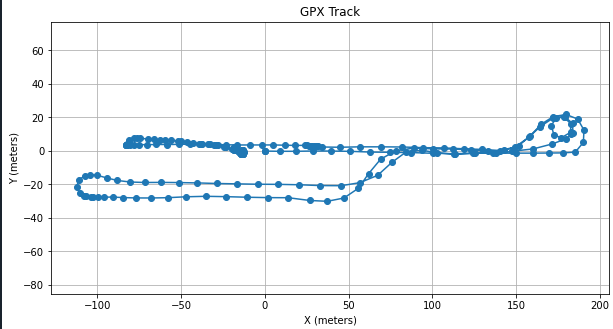

Avec une fenêtre de 5 et un polynôme d'ordre 3 : 

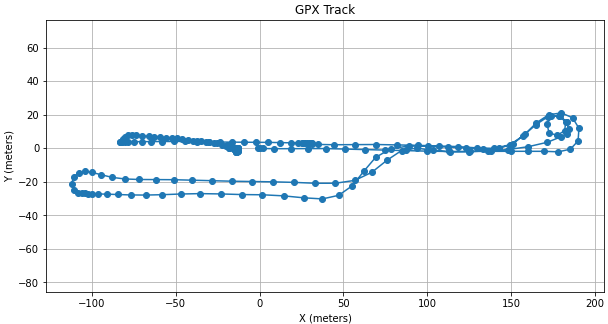

Avec une fenêtre de 7 et un polynôme d'ordre 3 : 

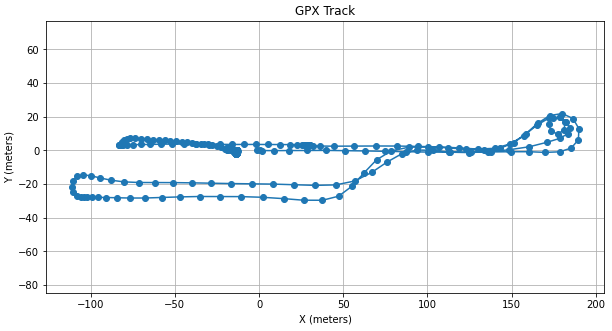

Avec une fenêtre de 11 et un polynôme d'ordre 3 : 

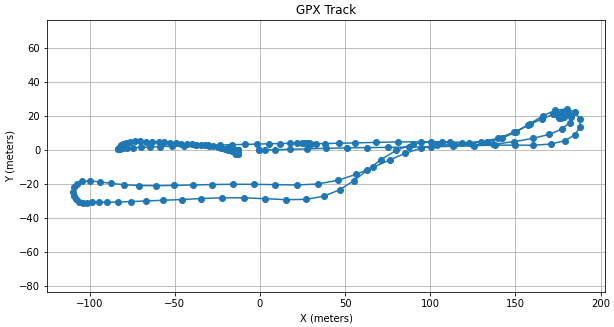


On se rend compte que le filtre, en moyennant la position des points, réduit le rayon du demi-tour, le faisant même disparaitre pour une fenêtre trop grande. 

Alors, le filtre utilisé n'est pas satisfaisant pour la génération de la table de rayon de courbure. 

A ce titre, le traitement de données doit se faire de façon plus spécifique. 
Une première approche pourrait être de supprimer les rayons de courbure trop petits, que l'on suppose du au bruit. Or cette approche invisibilise les tendances générales : par exemple, si le véhicule tourne à très faible vitesse, le bruit va générer un rayon de braquage trop petit pour être suivi, et remplacer par 0 le rayon de courbure causera une perte d'information et fausserait les résultats. 

Une seconde approche est développée dans la fonction delete_points ci dessous. 
Soient 4 points A, B, C, D. Si le rayon de courbure au point B calculé à partir des positions de A, B et C est incohérant (trop petit pour être suivi en réalité), le point B est supprimé et un nouveau rayon de courbure est calculé entre A, C et D. 

Cette fonction est itérée dans la fonction clean_coords jusqu'à ce que tous les rayons de courbures soient possibles à négocier avec le Goupil. 

In [2]:
def delete_points(rotated_coords, longitudinal_coords):
    """Calculates the signed curvature radius for each segment of the trajectory."""
    coords = []
    coordslongitudinal = []
    coordslongitudinal.append(longitudinal_coords[0])
    coords.append(rotated_coords[0])
    
    for i in range(1, len(rotated_coords) - 1):
        x1, y1 = rotated_coords[i - 1]
        x2, y2 = rotated_coords[i]
        x3, y3 = rotated_coords[i + 1]
        
        # Calculate side lengths
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        
        # Calculate area of the triangle
        s = (a + b + c) / 2
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        if area == 0 or (a * b * c) == 0:
            radius = float('inf')
        else:
            radius = (a * b * c) / (4 * area)
            
        if radius>3 or radius<-3: 
            coords.append(rotated_coords[i])
            coordslongitudinal.append(longitudinal_coords[i])
            
    coords.append(rotated_coords[-1])
    coordslongitudinal.append(longitudinal_coords[-1])
    return coords, coordslongitudinal


def clean_coords(rotated_coords, longitudinal_coords):
    coords1, coordslat = delete_points(rotated_coords, longitudinal_coords)
    coords2, coordslat2 = delete_points(coords1, coordslat)
    
    while not(len(coords1)==len(coords2)):
        coords1, coordslat = delete_points(coords2, coordslat2)
        coords2, coordslat2 = delete_points(coords1, coordslat)
    return coords1, coordslat


### Conclusion
Cette fois-ci, les résultats sont tout à fait satisafaisants, l'allure générale du circuit est conservé et les incohérences sont supprimées. 
Le filtre de Savitzky Golay, qui n'est pas pertinant pour le calcul du rayon de courbure, est utilisé pour lisser le profil de vitesse. 

Le code au complet est donné ci dessous : 

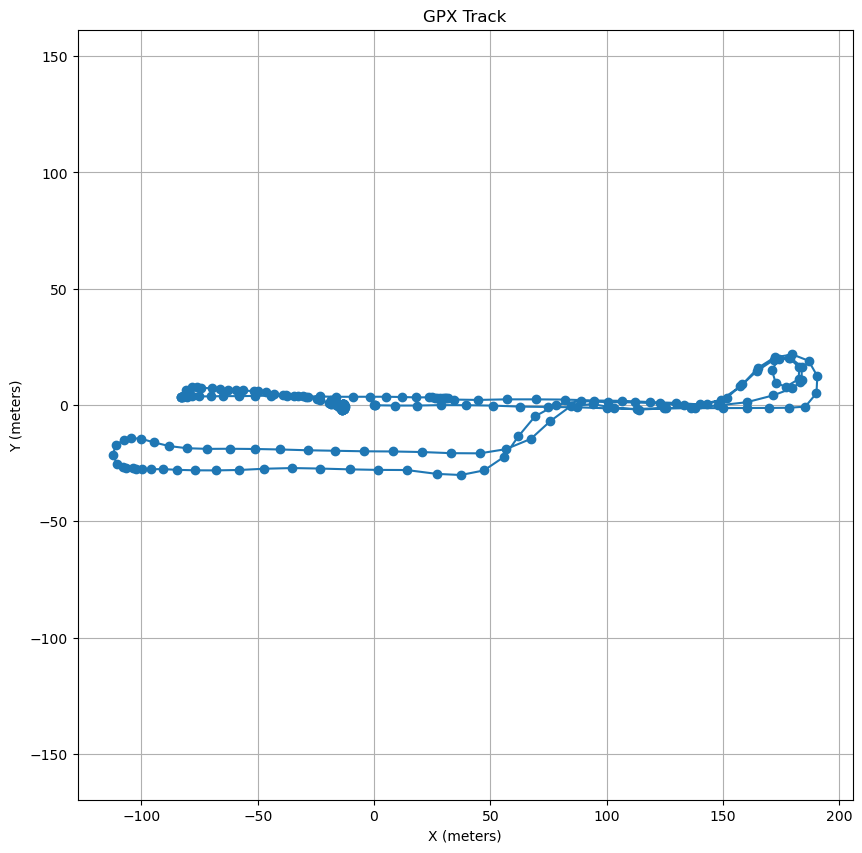

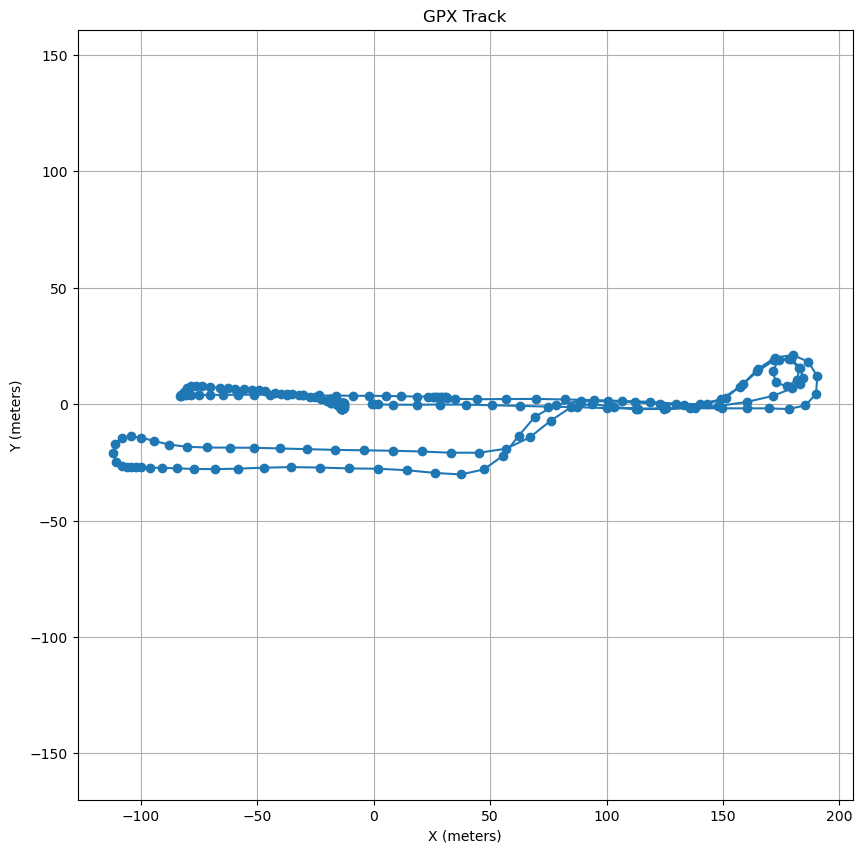

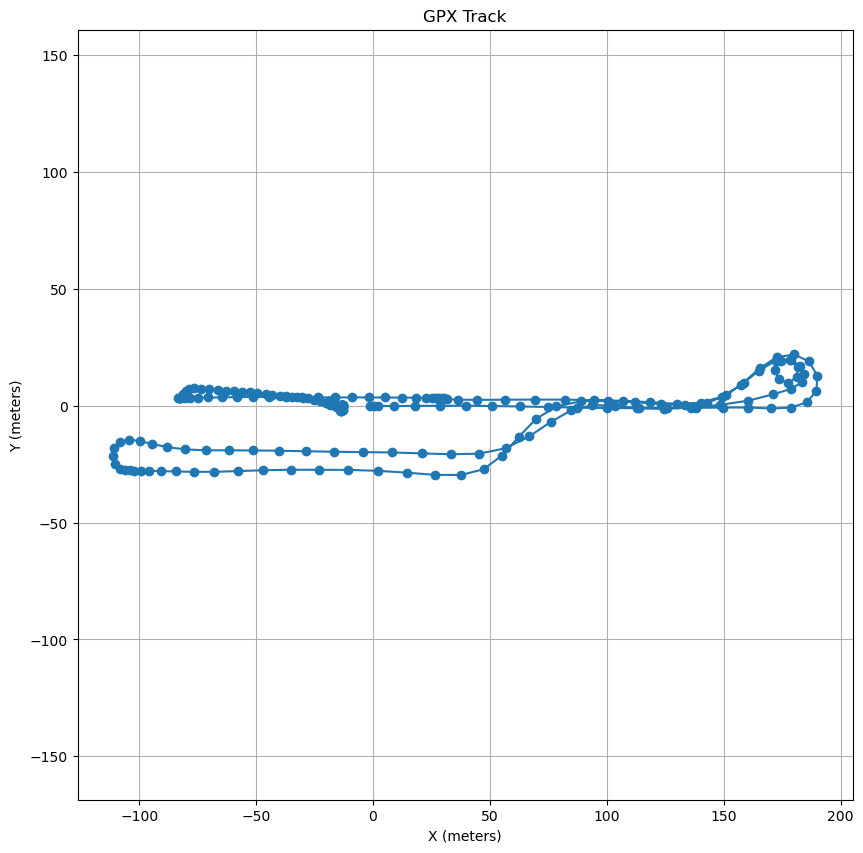

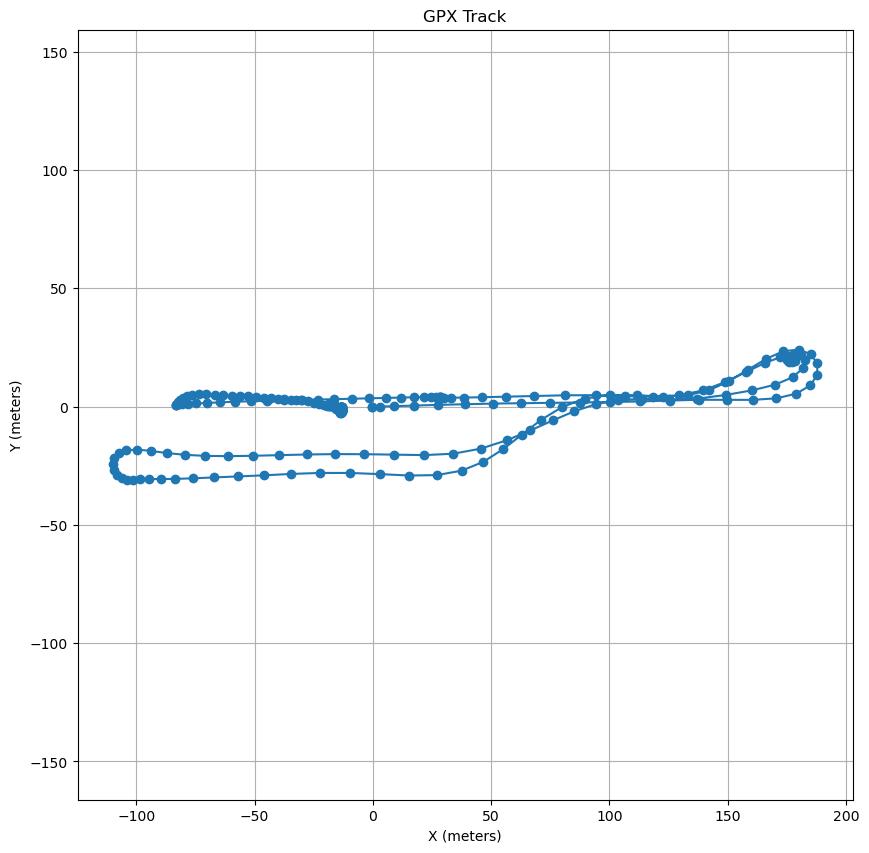

178


C:\Users\eliot\AppData\Local\Temp\ipykernel_18940\710895939.py:283: RuntimeWarning: invalid value encountered in sqrt
  area = np.sqrt(s * (s - a) * (s - b) * (s - c))


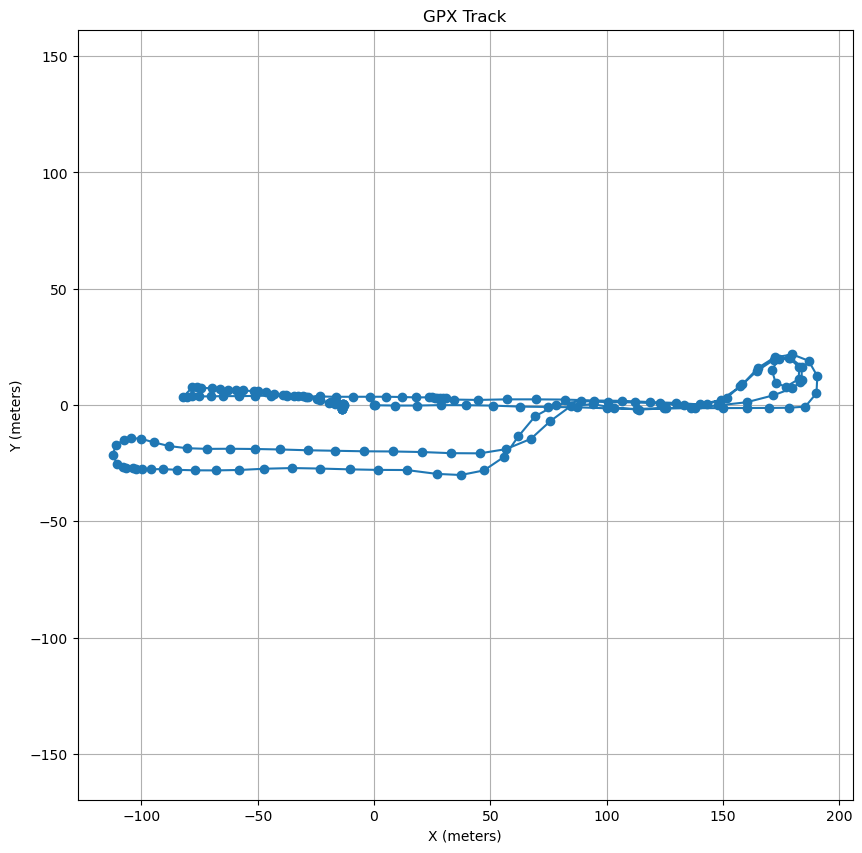

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Sep 8 23:18:47 2024

@author: Eliot Lages
"""

import gpxpy
import gpxpy.gpx
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import savgol_filter

# ================================
# Lecture et exploitaion du GPX
# ================================

def read_gpx_file(file_path):
    """Reads a GPX file and parses it."""
    with open(file_path, 'r') as gpx_file:
        gpx = gpxpy.parse(gpx_file)
    return gpx

def extract_coordinates_and_times(gpx):
    """Extracts latitude, longitude, and timestamp from GPX data."""
    coords = []
    times = []
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                coords.append((point.latitude, point.longitude))
                times.append(point.time)
    return coords[62:], times[62:]  # Skip the first 10 points

def latlon_to_cartesian(lat, lon, origin_lat, origin_lon):
    """Converts latitude and longitude to Cartesian coordinates in meters with a given origin."""
    # Earth radius in meters
    R = 6378137.0
    # Convert degrees to radians
    lat_rad = np.radians(lat)
    lon_rad = np.radians(lon)
    origin_lat_rad = np.radians(origin_lat)
    origin_lon_rad = np.radians(origin_lon)
    
    # Calculate deltas
    delta_lat = lat_rad - origin_lat_rad
    delta_lon = lon_rad - origin_lon_rad
    
    # Calculate x and y in meters
    x = R * delta_lon * np.cos(origin_lat_rad)
    y = R * delta_lat
    
    return x, y

def transform_coordinates(coords):
    """Transforms a list of GPS coordinates to Cartesian coordinates with the first point as origin."""
    origin_lat, origin_lon = coords[0]
    cartesian_coords = [latlon_to_cartesian(lat, lon, origin_lat, origin_lon) for lat, lon in coords]
    return cartesian_coords

def calculate_initial_angle(cartesian_coords):
    """Calculates the initial angle of the trajectory."""
    x1, y1 = cartesian_coords[15]
    x2, y2 = cartesian_coords[16]
    angle = np.arctan2(y2 - y1, x2 - x1)
    return angle

def rotate_coordinates(cartesian_coords, angle):
    """Rotates the coordinates to align the initial direction with the x-axis."""
    rotation_matrix = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    rotated_coords = [np.dot(rotation_matrix, [x, y]) for x, y in cartesian_coords]
    return rotated_coords

def normalize_time_data(time_distance_data):
    """Normalizes the time column to start at t=0 and converts to seconds."""
    # Convert timestamps to seconds since the start
    initial_time = time_distance_data[0][0]  # Get the initial timestamp
    normalized_time_distance_data = []
    
    for timestamp, distance in time_distance_data:
        normalized_time = (timestamp - initial_time).total_seconds()  # Normalize time to seconds
        normalized_time_distance_data.append((normalized_time, distance))
    
    return normalized_time_distance_data


# =======================
# Calcul de la distance
# =======================

def haversine(lat1, lon1, lat2, lon2):
    """Calculates the Haversine distance between two GPS points."""
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.asin(math.sqrt(a))
    r = 6371  # Earth radius in kilometers
    return c * r * 1000  # Convert to meters

def calculate_distances(coords):
    """Calculates distances between successive points and cumulative distances."""
    distances = [0]  # Initialize with zero distance
    total_distance = 0
    for i in range(1, len(coords)):
        dist = haversine(*coords[i - 1], *coords[i])
        total_distance += dist
        distances.append(total_distance)
    return distances


# =======================
# Nettoyage des données
# =======================

def apply_savitzky_golay_filter(coords, times, window_length=5, polyorder=3):
    """Applique un filtre de Savitzky-Golay pour lisser les données de coordonnées X et Y."""
    times = np.array([(t - times[0]).total_seconds() for t in times])  # Convertir le temps en secondes
    x_coords = np.array([coord[0] for coord in coords])
    y_coords = np.array([coord[1] for coord in coords])

    # Application du filtre de Savitzky-Golay
    smoothed_x = savgol_filter(x_coords, window_length, polyorder)
    smoothed_y = savgol_filter(y_coords, window_length, polyorder)

    return list(zip(smoothed_x, smoothed_y))

def remove_duplicate_distances(data):
    """Removes rows with duplicate distances, keeping only the first occurrence."""
    seen = set()
    unique_data = []
    for row in data:
        distance = row[0]
        if distance not in seen:
           seen.add(distance)
           unique_data.append(row)
    return unique_data

# =====================================
# Calcul de la vitesse et accélération
# =====================================

def calculate_velocity_acceleration(smoothed_x, smoothed_y, times):
    """Calcule la vitesse et l'accélération à partir des coordonnées lissées."""
    times_seconds = np.array([(t - times[0]).total_seconds() for t in times])

    # Calcul des vitesses (dérivée des positions)
    vx = np.gradient(smoothed_x, times_seconds)  # Vitesse en x
    vy = np.gradient(smoothed_y, times_seconds)  # Vitesse en y
    speed = np.sqrt(vx**2 + vy**2)  # Vitesse totale

    # Calcul des accélérations (dérivée des vitesses)
    ax = np.gradient(vx, times_seconds)
    ay = np.gradient(vy, times_seconds)
    acceleration = np.sqrt(ax**2 + ay**2)  # Accélération totale

    return speed, acceleration


# =========================
# Affichage et enregistrement 
# =========================

def save_to_txt(data, file_path):
    """Saves the data to a TXT file."""
    with open(file_path, 'w') as file:
        for row in data:
            file.write(" ".join(map(str, row)) + "\n")

def plot_coordinates(coords):
    """Plots the given coordinates on a 2D plane."""
    x_coords, y_coords = zip(*coords)
    plt.figure(figsize=(10, 10))
    plt.plot(x_coords, y_coords, marker='o')
    plt.title('GPX Track')
    plt.xlabel('X (meters)')
    plt.ylabel('Y (meters)')
    plt.grid()
    plt.axis('equal')
    plt.show()


# Read the GPX file
gpx_file_path = 'C:/Users/eliot/Documents/Goupil/GPX/Test_2.gpx' #A modifier selon l'emplacement local du dichier gpx
gpx = read_gpx_file(gpx_file_path)

# Extract coordinates and times
latlon_coords, timestamps = extract_coordinates_and_times(gpx)
cartesian_coords = transform_coordinates(latlon_coords)
initial_angle = calculate_initial_angle(cartesian_coords)
rotated_coords = rotate_coordinates(cartesian_coords, -initial_angle)
plot_coordinates(rotated_coords)

# Extract coordinates and times filtered data
cartesian_coords_filtered = apply_savitzky_golay_filter(cartesian_coords, timestamps,5 ,3)
initial_angle_2 = calculate_initial_angle(cartesian_coords_filtered)
rotated_coords_2 = rotate_coordinates(cartesian_coords_filtered, -initial_angle_2)
plot_coordinates(rotated_coords_2)


# Extract coordinates and times filtered data
cartesian_coords_filtered = apply_savitzky_golay_filter(cartesian_coords, timestamps,7 ,3)
initial_angle_2 = calculate_initial_angle(cartesian_coords_filtered)
rotated_coords_2 = rotate_coordinates(cartesian_coords_filtered, -initial_angle_2)
plot_coordinates(rotated_coords_2)

# Extract coordinates and times filtered data
cartesian_coords_filtered = apply_savitzky_golay_filter(cartesian_coords, timestamps,11 ,3)
initial_angle_2 = calculate_initial_angle(cartesian_coords_filtered)
rotated_coords_2 = rotate_coordinates(cartesian_coords_filtered, -initial_angle_2)
plot_coordinates(rotated_coords_2)



# =======================================================
# Calcul du rayon de courbure avec les données lissées
# =======================================================

def calculate_curvature_radius_with_sign(rotated_coords):
    """Calculates the signed curvature radius for each segment of the trajectory."""
    signed_radii = [float('inf')]  # Initialize with a large value (for straight line) for the first point
    for i in range(1, len(rotated_coords) - 1):
        x1, y1 = rotated_coords[i - 1]
        x2, y2 = rotated_coords[i]
        x3, y3 = rotated_coords[i + 1]
        
        # Calculate side lengths
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        
        # Calculate area of the triangle
        s = (a + b + c) / 2
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        if area == 0 or (a * b * c) == 0:
            radius = float('inf')
        else:
            radius = (a * b * c) / (4 * area)
        
        # Determine the sign of the curvature
        cross_product = (x2 - x1) * (y3 - y1) - (y2 - y1) * (x3 - x1)
        signed_radius = radius if cross_product > 0 else -radius
        
        signed_radii.append(signed_radius)
    signed_radii.append(float('inf'))  # Append a large value for the last point
    return signed_radii

def replace_incoherent_angles(data, min_value=-1/5, max_value=1/5):
    """Replaces angles with 0 where the inverse curvature radius is outside the expected range."""
    corrected_data = []
    for distance, inverse_radius in data:
        if min_value <= inverse_radius <= max_value:
            corrected_data.append((distance, inverse_radius))
        else:
            corrected_data.append((distance, 0))  # Remplace l'angle par 0
    return corrected_data

# =======================================================
# Calcul du rayon de courbure avec des données cohérentes
# =======================================================

def delete_points(rotated_coords, longitudinal_coords):
    """Calculates the signed curvature radius for each segment of the trajectory."""
    coords = []
    coordslongitudinal = []
    coordslongitudinal.append(longitudinal_coords[0])
    coords.append(rotated_coords[0])
    
    for i in range(1, len(rotated_coords) - 1):
        x1, y1 = rotated_coords[i - 1]
        x2, y2 = rotated_coords[i]
        x3, y3 = rotated_coords[i + 1]
        
        # Calculate side lengths
        a = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        b = np.sqrt((x3 - x2)**2 + (y3 - y2)**2)
        c = np.sqrt((x3 - x1)**2 + (y3 - y1)**2)
        
        # Calculate area of the triangle
        s = (a + b + c) / 2
        area = np.sqrt(s * (s - a) * (s - b) * (s - c))
        
        if area == 0 or (a * b * c) == 0:
            radius = float('inf')
        else:
            radius = (a * b * c) / (4 * area)
            
        if radius>3 or radius<-3: 
            coords.append(rotated_coords[i])
            coordslongitudinal.append(longitudinal_coords[i])
            
    coords.append(rotated_coords[-1])
    coordslongitudinal.append(longitudinal_coords[-1])
    return coords, coordslongitudinal


def clean_coords(rotated_coords, longitudinal_coords):
    coords1, coordslat = delete_points(rotated_coords, longitudinal_coords)
    coords2, coordslat2 = delete_points(coords1, coordslat)
    
    while not(len(coords1)==len(coords2)):
        coords1, coordslat = delete_points(coords2, coordslat2)
        coords2, coordslat2 = delete_points(coords1, coordslat)
    return coords1, coordslat

coords_clean, lat_clean = clean_coords(rotated_coords, latlon_coords)
radius = calculate_curvature_radius_with_sign(coords_clean)
distance = calculate_distances(lat_clean)

print(len(radius))
#plot_coordinates(coords_clean)

#CAlculate the inverse radii
inverse_curvature_radii = [1 / r if r != 0 else 0 for r in radius]

# Combine distances and inverse curvature radii into a single dataset
distance_inverse_radius_data = list(zip(distance, inverse_curvature_radii))

# Remove duplicate distances
unique_distance_inverse_radius_data = remove_duplicate_distances(distance_inverse_radius_data)

plot_coordinates(coords_clean)
# Save to TXT
#save_to_txt(unique_distance_inverse_radius_data, 'C:/Users/eliot/Documents/Goupil/GPX/distance_inverse_radius_final.txt')